In [1]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CelebA.zip

1. Import libraries

In [3]:
#First we import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from IPython.display import HTML
from __future__ import print_function

2. We load the database and visualize the training set.

In [ ]:
# Where is our database located?
path = '/content/processed_celeba_small/celeba'

# Let's see that the data has been loaded in the correct format.
print(os.listdir(path))

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


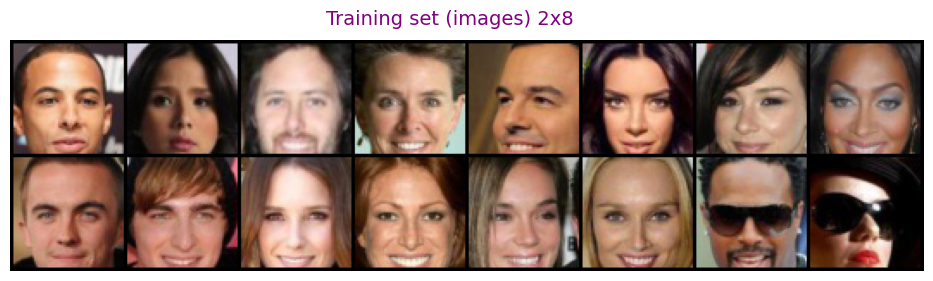

In [5]:
# Size of the input images
image_size = 64

# Set the number of workers and batch size.
workers = 4
batch_size = 128

# Number of GPUs.
ngpu = 1

# Setting the data base and dataloader.
dataset = dset.ImageFolder(path,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Set device
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# View some of our images of the training set.
real_batch = next(iter(dataloader))
plt.figure(figsize=(14,3))
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.suptitle("Training set (images) 2x8", fontsize=14, color='purple')
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))


3. We define the functions that we will use to run the code (Generator and discriminator).

In [6]:
# Initialization for netG and netD.
def initialize_weights(module):
    class_name = module.__class__.__name__
    if 'Conv' in class_name:
        nn.init.normal_(module.weight.data, mean=0.0, std=0.02)
    elif 'BatchNorm' in class_name:
        nn.init.normal_(module.weight.data, mean=1.0, std=0.02)
        nn.init.constant_(module.bias.data, val=0.0)

# Generator model
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        # Layers
        self.main = nn.Sequential(
            # 100D latent vector Z
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
            # Output : (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
# Channels in training images.
nc = 3
# z latent vector.
nz = 100
# Feature maps in generator.
ngf = 64

netG = Generator(ngpu).to(device)

# Multi-gpu
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Initialize the weights
netG.apply(initialize_weights)

# Print the model
print(netG)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        # Architecture
        self.main = nn.Sequential(
            # (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Feature maps in discriminator
ndf = 64

netD = Discriminator(ngpu).to(device)

# Multi-gpu
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Initialize the weights
netD.apply(initialize_weights)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [8]:
# Fixed batch of noise vectors.
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Beta1 hyperparam and learning rate.
beta1 = 0.5
lr = 0.0002

# Binary Cross Entropy Loss function
criterion = nn.BCELoss()

# Real and fake images batches.
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


4. It's time to train the model.

In [9]:
# Epochs
num_epochs = 10

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Training Loop:")

for epoch in range(num_epochs):

    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Real batch through D
        output = netD(real_cpu).view(-1)
        # Loss on all-real batch
        errD_real = criterion(output, label.float())
        # Gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        # Batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify fake batch with D
        output = netD(fake.detach()).view(-1)
        # D's loss on the all-fake batch
        errD_fake = criterion(output, label.float())
        # Calculate gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
 
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        # Another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # G's loss based on this output
        errG = criterion(output, label.float())
        # Gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item()))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        

Training Loop:
[0/10][0/448]	Loss_D: 2.0341	Loss_G: 4.9009
[0/10][50/448]	Loss_D: 0.3984	Loss_G: 29.3342
[0/10][100/448]	Loss_D: 0.9730	Loss_G: 9.0896
[0/10][150/448]	Loss_D: 0.7327	Loss_G: 9.8629
[0/10][200/448]	Loss_D: 0.4968	Loss_G: 5.5170
[0/10][250/448]	Loss_D: 0.5479	Loss_G: 3.0570
[0/10][300/448]	Loss_D: 0.5875	Loss_G: 4.7601
[0/10][350/448]	Loss_D: 0.4002	Loss_G: 4.3610
[0/10][400/448]	Loss_D: 0.3363	Loss_G: 5.2929
[1/10][0/448]	Loss_D: 0.7752	Loss_G: 5.4684
[1/10][50/448]	Loss_D: 0.7704	Loss_G: 6.0728
[1/10][100/448]	Loss_D: 0.3531	Loss_G: 4.7795
[1/10][150/448]	Loss_D: 0.5809	Loss_G: 6.1015
[1/10][200/448]	Loss_D: 0.4433	Loss_G: 3.5127
[1/10][250/448]	Loss_D: 0.2944	Loss_G: 5.4982
[1/10][300/448]	Loss_D: 0.6322	Loss_G: 6.8054
[1/10][350/448]	Loss_D: 0.5593	Loss_G: 2.9472
[1/10][400/448]	Loss_D: 0.2044	Loss_G: 4.3249
[2/10][0/448]	Loss_D: 0.2999	Loss_G: 3.4935
[2/10][50/448]	Loss_D: 0.6807	Loss_G: 2.9465
[2/10][100/448]	Loss_D: 0.2950	Loss_G: 4.2736
[2/10][150/448]	Loss_D: 0.3

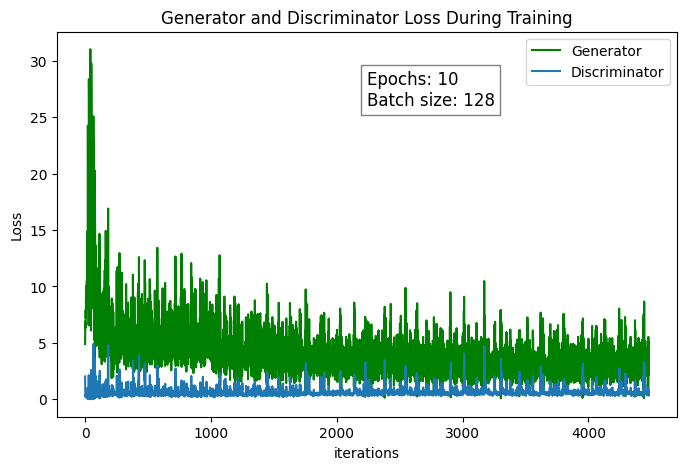

In [10]:
#Plotting the loss given iterations
plt.figure(figsize=(8,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator", c='g')
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

plt.text(0.5, 0.9, f'Epochs: {num_epochs}\nBatch size: {batch_size}',
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.show()


5. Final result.

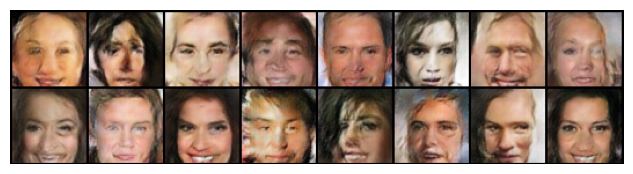

In [11]:
fig = plt.figure(figsize=(8, 2))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0))[:133, :, :], animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())
